<a href="https://colab.research.google.com/github/roa212003/AI/blob/main/CatsVsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import get_ipython
from IPython.display import display
# %%
from google.colab import files
!pip install -q kaggle
# %%
uploaded = files.upload()
# %%
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
# %%
!chmod 600 /root/.kaggle/kaggle.json
# %%
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset --force

# %%
!unzip /content/microsoft-catsvsdogs-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/PetImages/Dog/550.jpg  
  inflating: /content/dataset/PetImages/Dog/5500.jpg  
  inflating: /content/dataset/PetImages/Dog/5501.jpg  
  inflating: /content/dataset/PetImages/Dog/5502.jpg  
  inflating: /content/dataset/PetImages/Dog/5503.jpg  
  inflating: /content/dataset/PetImages/Dog/5504.jpg  
  inflating: /content/dataset/PetImages/Dog/5505.jpg  
  inflating: /content/dataset/PetImages/Dog/5506.jpg  
  inflating: /content/dataset/PetImages/Dog/5507.jpg  
  inflating: /content/dataset/PetImages/Dog/5508.jpg  
  inflating: /content/dataset/PetImages/Dog/5509.jpg  
  inflating: /content/dataset/PetImages/Dog/551.jpg  
  inflating: /content/dataset/PetImages/Dog/5510.jpg  
  inflating: /content/dataset/PetImages/Dog/5511.jpg  
  inflating: /content/dataset/PetImages/Dog/5512.jpg  
  inflating: /content/dataset/PetImages/Dog/5513.jpg  
  inflating: /content/dataset/PetImages/Dog/5514.jpg  
  inflating: /co

In [3]:
# Basic
import os
import shutil
from shutil import copyfile
import numpy as np
import pandas as pd
import tensorflow as tf
import random

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [4]:
# %%
valid_images = [".jpg", ".jpeg", ".png"]

def remove_invalid_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not file.lower().endswith(tuple(valid_images)):
                print(f"Invalid file found and removed: {file_path}")
                os.remove(file_path)
            else:
                try:
                    # Try opening the image using PIL to verify its validity.
                    Image.open(file_path).verify()
                except (IOError, SyntaxError) as e:
                    print(f"Corrupted image found and removed: {file_path} - {e}")
                    os.remove(file_path)

#remove any invalid image files
remove_invalid_images("/content/dataset/PetImages/Dog")
remove_invalid_images("/content/dataset/PetImages/Cat")
# %%

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Invalid file found and removed: /content/dataset/PetImages/Dog/Thumbs.db
Corrupted image found and removed: /content/dataset/PetImages/Dog/11702.jpg - cannot identify image file '/content/dataset/PetImages/Dog/11702.jpg'
Invalid file found and removed: /content/dataset/PetImages/Cat/Thumbs.db
Corrupted image found and removed: /content/dataset/PetImages/Cat/666.jpg - cannot identify image file '/content/dataset/PetImages/Cat/666.jpg'


In [5]:
try:
    os.makedirs('/content/tmp/cats-and-dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/training', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/validation', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/test', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/training/dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/training/cats', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/validation/dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/validation/cats', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/test/dogs', exist_ok = True)
    os.makedirs('/content/tmp/cats-and-dogs/test/cats', exist_ok = True)
except OSError:
    print("Failed to make directory")

In [6]:
def delete_all_files_in_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")

In [7]:
delete_all_files_in_directory('/content/tmp/cats-and-dogs/validation/dogs')
delete_all_files_in_directory('/content/tmp/cats-and-dogs/validation/cats')
delete_all_files_in_directory('/content/tmp/cats-and-dogs/test/dogs')
delete_all_files_in_directory('/content/tmp/cats-and-dogs/test/cats')

In [8]:
#define data path
dog_dir = '/content/dataset/PetImages/Dog'
cat_dir = '/content/dataset/PetImages/Cat'

training_dir =  '/content/tmp/cats-and-dogs/training'
validation_dir =  '/content/tmp/cats-and-dogs/validation'

training_cat = os.path.join(training_dir, 'cats/')
training_dog = os.path.join(training_dir, 'dogs/')

validation_cat = os.path.join(validation_dir, 'cats/')
validation_dog = os.path.join(validation_dir, 'dogs/')

In [9]:
# train test split using dataframe
def split_data(main_dir, training_dir, validation_dir, test_dir=None,  split_size=0.8):
    files =  []
    for f in os.listdir(main_dir):
        if len(os.path.join(main_dir,f)):
            files.append(f)

    shuffled_files = random.sample(files, len(files))
    split_index = int(len(shuffled_files)*split_size)

    X_train = shuffled_files[:split_index]
    split_val_index = int(split_index+(1-split_size)*len(shuffled_files)/2)
    X_val = shuffled_files[split_index:split_val_index]
    X_test = shuffled_files[split_val_index:len(shuffled_files)]

    for element in X_train:
        copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element))

    for element in X_val:
        copyfile(os.path.join(main_dir, element), os.path.join(validation_dir,element))

    for element in X_test:
        copyfile(os.path.join(main_dir, element), os.path.join(test_dir,element))
    print("Split successful!")

In [10]:
split_data(dog_dir, training_dog, validation_dog, '/content/tmp/cats-and-dogs/test/dogs', 0.8)
split_data(cat_dir, training_cat, validation_cat, '/content/tmp/cats-and-dogs/test/cats', 0.8)

Split successful!
Split successful!


In [11]:
remove_invalid_images("/content/tmp/cats-and-dogs/training/dogs")
remove_invalid_images("/content/tmp/cats-and-dogs/training/cats")
remove_invalid_images("/content/tmp/cats-and-dogs/validation/dogs")
remove_invalid_images("/content/tmp/cats-and-dogs/validation/cats")
remove_invalid_images("/content/tmp/cats-and-dogs/test/dogs")
remove_invalid_images("/content/tmp/cats-and-dogs/test/cats")

In [12]:
training_gen = ImageDataGenerator(rescale=1./255)

validation_gen =  ImageDataGenerator(rescale=1./255.)

test_gen =  ImageDataGenerator(rescale=1./255.)

In [13]:
training_generator = training_gen.flow_from_directory(
        '/content/tmp/cats-and-dogs/training',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary',
)

validation_generator = validation_gen.flow_from_directory(
        '/content/tmp/cats-and-dogs/validation',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

test_generator = test_gen.flow_from_directory(
        '/content/tmp/cats-and-dogs/test',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 19998 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


In [14]:
# Creating a function to visualize the images to check if we get the correct data
class_names = ['Cat', 'Dog']
def visualize_images(generator, num_images=5):
    i = 1
    images, labels = next(generator)
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))

    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == num_images:
            break

    plt.show()

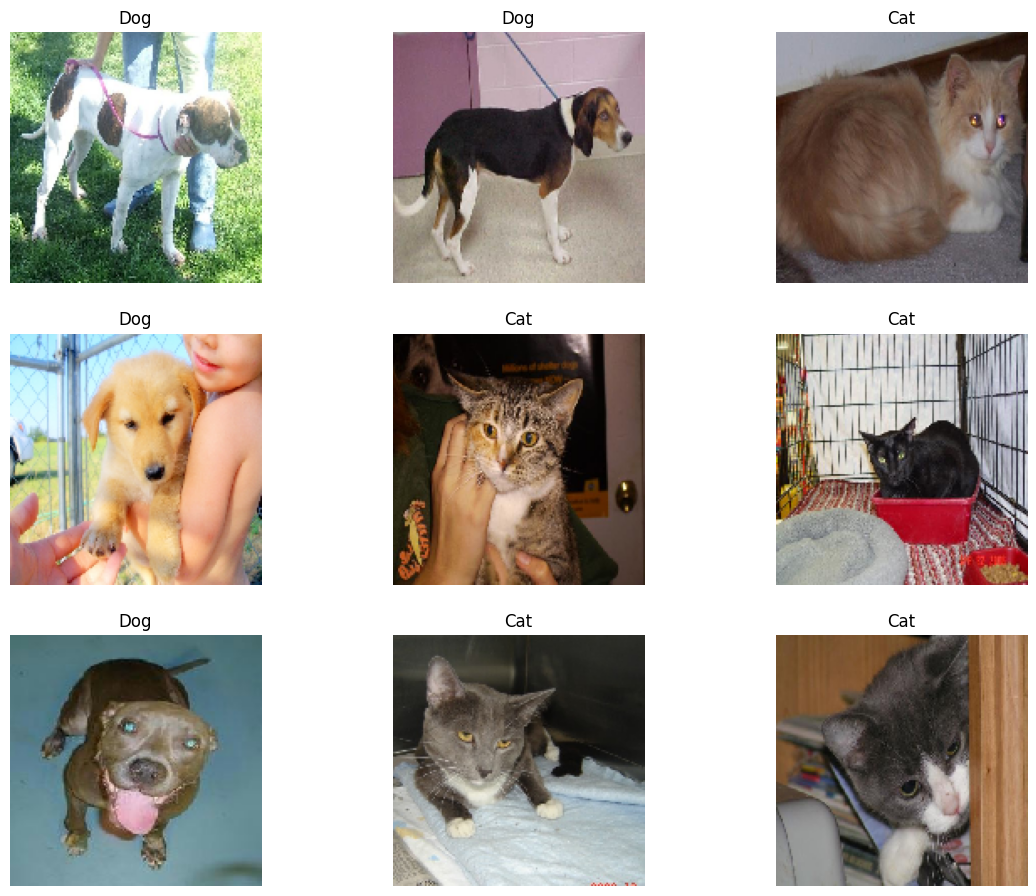

In [15]:
visualize_images(training_generator, 10)

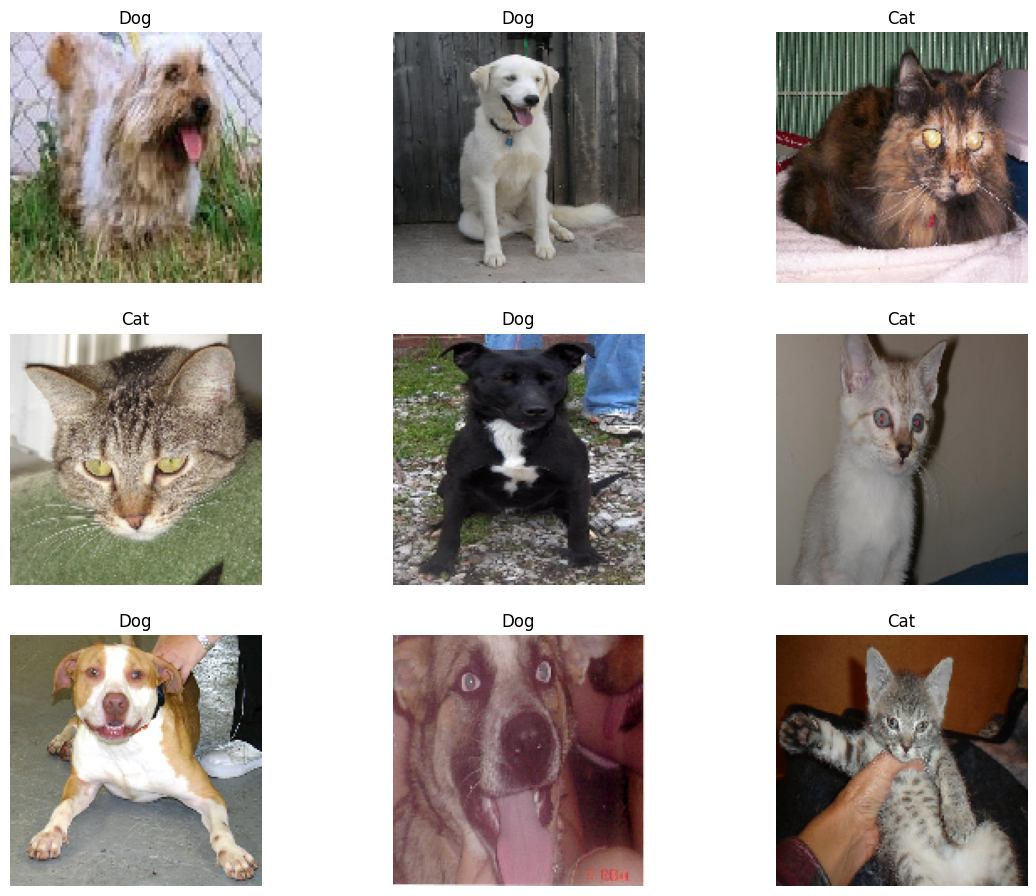

In [16]:
visualize_images(validation_generator, 10)

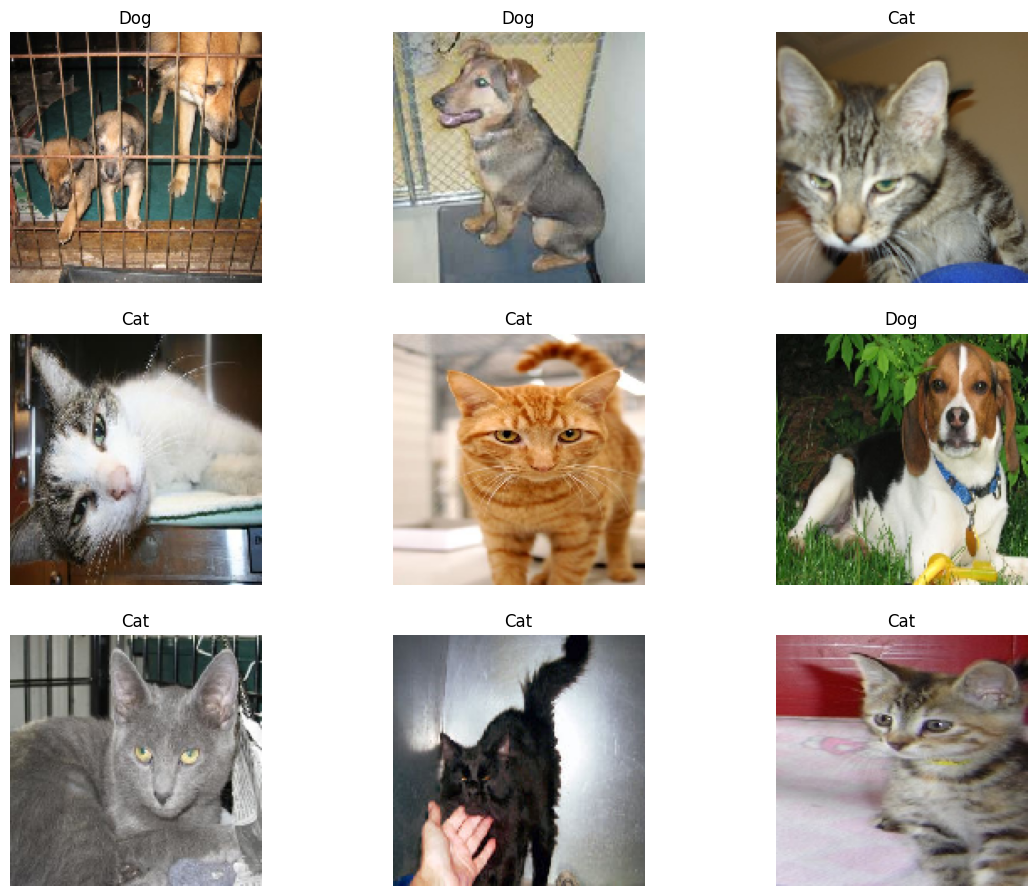

In [17]:
visualize_images(test_generator, 10)

In [19]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation = 'relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128, activation =  'relu'))
model.add(Dense(64, activation =  'relu'))
model.add(Dense(32, activation =  'relu'))

model.add(Dense(1, activation = 'sigmoid'))

In [20]:
model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_training = model.fit(
    training_generator,
    epochs=10,
    batch_size = 64,
    validation_data=validation_generator,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 16/313 ━━━━━━━━━━━━━━━━━━━━ 27:01 5s/step - accuracy: 0.4843 - loss: 1.1849

Visualize training process

In [ ]:
results = pd.DataFrame(r.history)
results.tail()